In [30]:
import numpy as np
import sys
if "../" not in sys.path:
    sys.path.append("../")
from lib import plotting
from lib.envs.random_walk import RandomWalk
from lib.envs.windy_gridworld import WindyGridworldEnv
import itertools
import matplotlib
from collections import defaultdict, OrderedDict

matplotlib.style.use('ggplot')


In [31]:
env2= RandomWalk()
env1 = WindyGridworldEnv()

In [32]:
def make_epsilon_greedy_policy(Q, epsilon):
    def policy(state):
        A = epsilon * np.ones(len(Q[state]), dtype=float)/len(Q[state])
        best_action = np.argmax(Q[state])
        A[best_action] += 1 - epsilon
        return A
    return policy

In [33]:
def n_step_sarsa(env, num_episodes, n, discount=1.0, alpha=0.4, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n, dtype=float))
    policy = make_epsilon_greedy_policy(Q, epsilon)
    
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    for ep in range(num_episodes):
        G = 0.0
        states = []
        actions = []
        rewards=[]
        T = float('inf')
        state = env.reset()
        action = np.random.choice(np.arange(env.action_space.n), p=policy(state))
        states.append(state)
        actions.append(action)
        for t in itertools.count():
            if t < T:
                next_state, reward, done, _ = env.step(action)
                rewards.append(reward)
                states.append(next_state)
                if done:
                    T = t+1
                else:
                    next_action = np.random.choice(np.arange(env.action_space.n), p=policy(next_state))
                    actions.append(next_action)
                stats.episode_rewards[ep] += reward
                stats.episode_lengths[ep] = t
            tau = t - n + 1
            if tau >= 0:
                for i in range(tau, min(tau+n, T)):
                    G = sum(discount**(i-tau) * rewards[i] for i in range(tau, min(tau+n, T)))
                if tau + n < T:
                    G += discount**n * Q[states[tau+n]][actions[tau+n]]
                Q[states[tau]][actions[tau]] += alpha * (G - Q[states[tau]][actions[tau]])

            action = next_action
            if tau == T-1:
                break
    return Q, policy, stats

In [34]:
Q, policy, stats = n_step_sarsa(env1, num_episodes=20, n=4)

In [35]:
# V = defaultdict(float)
# for state, actions in Q.items():
#     action_value = np.max(actions)
#     V[state] = action_value
# od = OrderedDict(sorted(V.items()))

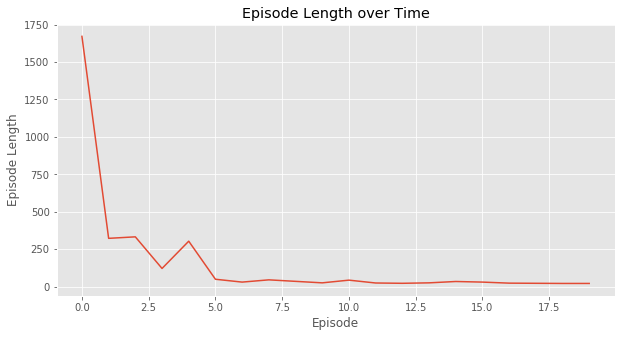

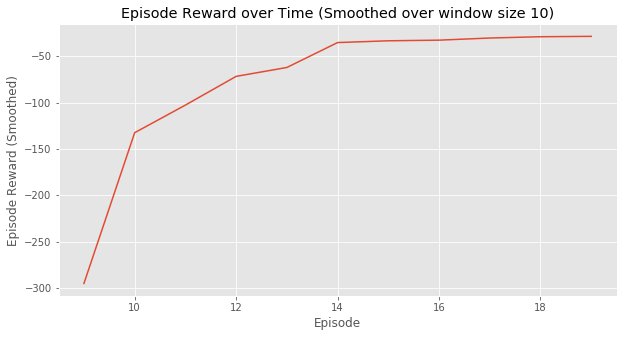

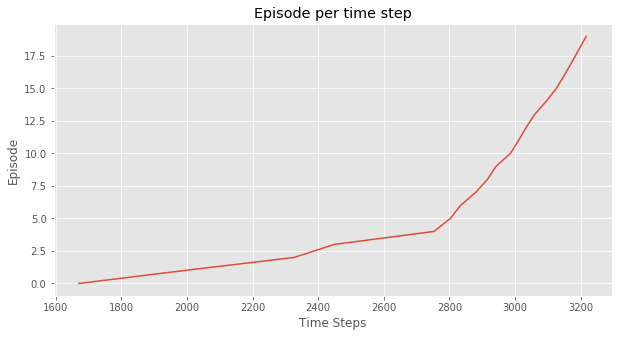

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [36]:
plotting.plot_episode_stats(stats)